<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Env" data-toc-modified-id="Env-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Env</a></span></li><li><span><a href="#Making-an-optimal-policy-gridworld" data-toc-modified-id="Making-an-optimal-policy-gridworld-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Making an optimal policy gridworld</a></span></li><li><span><a href="#TD-Control:-SARSA" data-toc-modified-id="TD-Control:-SARSA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TD Control: SARSA</a></span></li><li><span><a href="#Q-Learning" data-toc-modified-id="Q-Learning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Q Learning</a></span></li><li><span><a href="#Expected-SARSA" data-toc-modified-id="Expected-SARSA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Expected SARSA</a></span></li></ul></div>

In [2]:
import sys
import gym
import numpy as np
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

## Env 

In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


## Making an optimal policy gridworld

/Users/lordvile/anaconda/envs/new/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


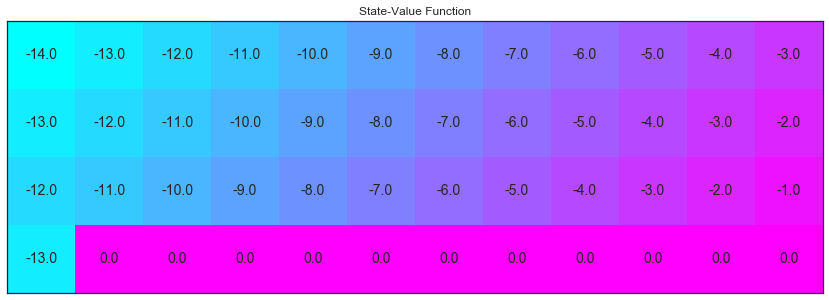

In [7]:
V_opt = np.zeros((4, 12))
V_opt[0][0:13] = -np.arange(3, 15)[::-1]
V_opt[1][0:13] = -np.arange(3, 15)[::-1] + 1
V_opt[2][0:13] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13
plot_values(V_opt)

## TD Control: SARSA

In [8]:
def update_Q_sarsa(alpha,
                   gamma,
                   Q,
                   state,
                   action,
                   reward,
                   next_state=None,
                   next_action=None):
    current_q = Q[state][action]
    next_q = Q[next_state][next_action] if next_state is not None else 0
    target_q = reward + (gamma * next_q)
    new_q = current_q + (alpha * (target_q - current_q))
    return new_q


def epsilon_greedy_fn(Q, state, action_space, eps):
    if random.random() > eps:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(action_space))

In [11]:
def sarsa(env, num_ep, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))

    temp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_ep)

    for i_ep in range(1, num_ep + 1):
        if i_ep % 100 == 0:
            print("\rEpisode {}/{}".format(i_ep, num_ep), end="")
            sys.stdout.flush()
        score = 0
        state = env.reset()

        eps = 1.0 / i_ep
        action = epsilon_greedy_fn(Q, state, nA, eps)

        while True:
            next_state, reward, done, infp = env.step(action)
            score += reward
            if not done:
                next_action = epsilon_greedy_fn(Q,next_state,nA,eps)
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state,
                                                  action, reward, next_state,
                                                  next_action)
                state = next_state
                action = next_action
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state,
                                                  action, reward)
                temp_scores.append(score)
                break

        if (i_ep % plot_every == 0):
            avg_scores.append(np.mean(temp_scores))

    plt.plot(
        np.linspace(0, num_ep, len(avg_scores), endpoint=False),
        np.asarray(avg_scores))
    plt.xlabel('Ep No')
    plt.ylabel('Avg reward over next {} episodes'.format(plot_every))
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every),
          np.max(avg_scores))
    return Q

Episode 50000/50000

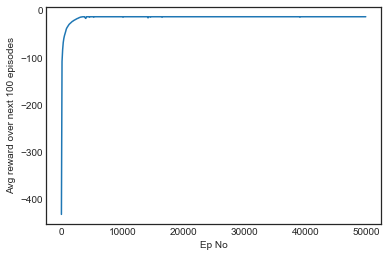

Best Average Reward over 100 Episodes:  -13.0

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  0  0  1  1  1  1  1  0  1  2  2]
 [ 1  2  0  2  1  1  1  1  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


In [17]:
Q_sarsa = sarsa(env, 50000, .01)
policy_sarsa = np.array([
    np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)
]).reshape(4, 12)

print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])

## Q Learning

In [21]:
def update_Q_sarsamax(alpha,
                   gamma,
                   Q,
                   state,
                   action,
                   reward,
                   next_state=None):
    current_q = Q[state][action]
    next_q = np.max(Q[next_state]) if next_state is not None else 0
    target_q = reward + (gamma * next_q)
    new_q = current_q + (alpha * (target_q - current_q))
    return new_q


In [22]:
def q_learning(env, num_ep, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))

    temp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_ep)

    for i_ep in range(1, num_ep + 1):
        if i_ep % 100 == 0:
            print("\rEpisode {}/{}".format(i_ep, num_ep), end="")
            sys.stdout.flush()
        score = 0
        state = env.reset()

        eps = 1.0 / i_ep
        

        while True:
            action = epsilon_greedy_fn(Q, state, nA, eps)
            next_state, reward, done, infp = env.step(action)
            score += reward
            if not done:
                next_action = epsilon_greedy_fn(Q,next_state,nA,eps)
                Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, state,
                                                  action, reward, next_state)
                state = next_state
            if done:
                temp_scores.append(score)
                break

        if (i_ep % plot_every == 0):
            avg_scores.append(np.mean(temp_scores))

    plt.plot(
        np.linspace(0, num_ep, len(avg_scores), endpoint=False),
        np.asarray(avg_scores))
    plt.xlabel('Ep No')
    plt.ylabel('Avg reward over next {} episodes'.format(plot_every))
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every),
          np.max(avg_scores))
    return Q

Episode 50000/50000

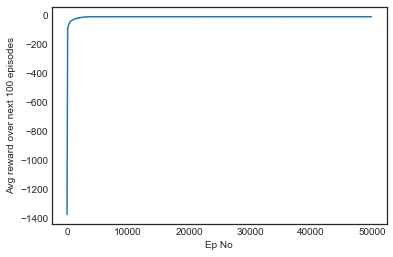

Best Average Reward over 100 Episodes:  -13.0

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  2  3  3  1  1  1  1  1  2  2]
 [ 0  1  1  0  1  1  2  1  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


In [23]:
Q_sarsamax = q_learning(env, 50000, .01)
policy_sarsamax = np.array([
    np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)
]).reshape(4, 12)

print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

V_sarsa = ([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

## Expected SARSA

In [24]:
def update_Q_expecsarsa(alpha,
                        gamma,
                        nA,
                        eps,
                        Q,
                        state,
                        action,
                        reward,
                        next_state=None):
    current_q = Q[state][action]
    policy_s = np.ones(nA)*eps/nA
    policy_s[np.argmax(Q[next_state])] = 1- eps+(eps/nA)
    next_q = np.dot(Q[next_state],policy_s) 
    target_q = reward + (gamma * next_q)
    new_q = current_q + (alpha * (target_q - current_q))
    return new_q

In [25]:
def q_learning(env, num_ep, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))

    temp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_ep)

    for i_ep in range(1, num_ep + 1):
        if i_ep % 100 == 0:
            print("\rEpisode {}/{}".format(i_ep, num_ep), end="")
            sys.stdout.flush()
        score = 0
        state = env.reset()

        eps = .005 # fixed
        

        while True:
            action = epsilon_greedy_fn(Q, state, nA, eps)
            next_state, reward, done, infp = env.step(action)
            score += reward
            Q[state][action] = update_Q_expecsarsa(alpha, gamma, nA,eps,Q, state,
                                              action, reward, next_state)
            state = next_state
            if done:
                temp_scores.append(score)
                break

        if (i_ep % plot_every == 0):
            avg_scores.append(np.mean(temp_scores))

    plt.plot(
        np.linspace(0, num_ep, len(avg_scores), endpoint=False),
        np.asarray(avg_scores))
    plt.xlabel('Ep No')
    plt.ylabel('Avg reward over next {} episodes'.format(plot_every))
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every),
          np.max(avg_scores))
    return Q

Episode 5000/5000

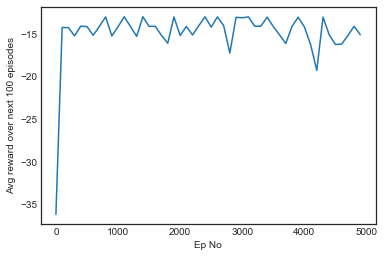

Best Average Reward over 100 Episodes:  -13.02

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


In [36]:
Q_expecsarsa = q_learning(env, 5000, .9)
policy_expecsars = np.array([
    np.argmax(Q_expecsarsa[key]) if key in Q_expecsarsa else -1 for key in np.arange(48)
]).reshape(4, 12)

print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expecsars)

V_sarsa = ([np.max(Q_expecsarsa[key]) if key in Q_expecsarsa else 0 for key in np.arange(48)])